In [17]:
! pip install -q kaggle

In [18]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [19]:
! cp kaggle.json ~/.kaggle/

In [20]:
! chmod 600 ~/.kaggle/kaggle.json

In [21]:
! kaggle datasets download kmader/skin-cancer-mnist-ham10000

 99% 5.17G/5.20G [00:42<00:00, 129MB/s]
100% 5.20G/5.20G [00:42<00:00, 131MB/s]


In [22]:
! unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [46]:
dataset = pd.read_csv('HAM10000_metadata.csv')

In [47]:
le = LabelEncoder()
le.fit(dataset['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [48]:
dataset['label'] = le.transform(dataset["dx"])


In [49]:
print(dataset['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [67]:
from sklearn.utils import resample
df_0 = dataset[dataset['label'] == 0]
df_1 = dataset[dataset['label'] == 1]
df_2 = dataset[dataset['label'] == 2]
df_3 = dataset[dataset['label'] == 3]
df_4 = dataset[dataset['label'] == 4]
df_5 = dataset[dataset['label'] == 5]
df_6 = dataset[dataset['label'] == 6]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)


In [68]:
dataset_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(dataset_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [50]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('*', '*.jpg'))}

In [ ]:
image_path

In [70]:
SIZE = 32

In [71]:
dataset_balanced['path'] = dataset['image_id'].map(image_path.get)
#Use the path to read images.
dataset_balanced['image'] = dataset_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


In [72]:
X = np.asarray(dataset_balanced['image'].tolist())
X = X/255.
Y=dataset_balanced['label']
Y_cat = to_categorical(Y, num_classes=7)
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [80]:
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 15, 15, 256)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 6, 6, 128)        

In [81]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


In [82]:
batch_size = 16
epochs = 100

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=1)



Epoch 1/100
165/165 [==============================] - 23s 132ms/step - loss: 1.9160 - acc: 0.1844 - val_loss: 1.8431 - val_acc: 0.2606
Epoch 2/100
165/165 [==============================] - 20s 122ms/step - loss: 1.7245 - acc: 0.2808 - val_loss: 1.6915 - val_acc: 0.2731
Epoch 3/100
165/165 [==============================] - 21s 126ms/step - loss: 1.5507 - acc: 0.3650 - val_loss: 1.5100 - val_acc: 0.3429
Epoch 4/100
165/165 [==============================] - 21s 126ms/step - loss: 1.4648 - acc: 0.4099 - val_loss: 1.4114 - val_acc: 0.4183
Epoch 5/100
165/165 [==============================] - 20s 122ms/step - loss: 1.4034 - acc: 0.4438 - val_loss: 1.4351 - val_acc: 0.4286
Epoch 6/100
165/165 [==============================] - 21s 126ms/step - loss: 1.4065 - acc: 0.4396 - val_loss: 1.3415 - val_acc: 0.4777
Epoch 7/100
165/165 [==============================] - 22s 131ms/step - loss: 1.3305 - acc: 0.4758 - val_loss: 1.3503 - val_acc: 0.4457
Epoch 8/100
165/165 [===========================

In [83]:
score = model.evaluate(x_test, y_test)

28/28 [==============================] - 1s 53ms/step - loss: 0.7808 - acc: 0.7531


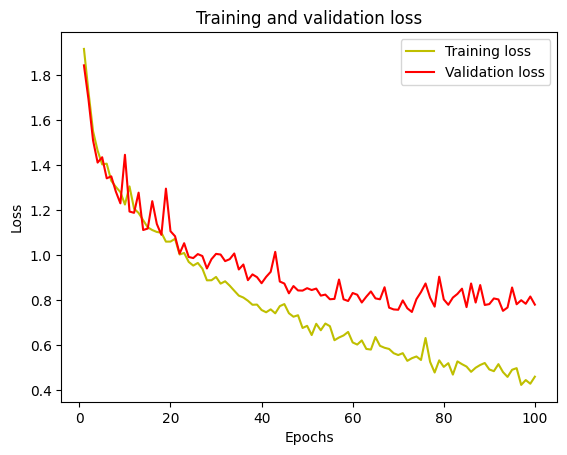

In [84]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


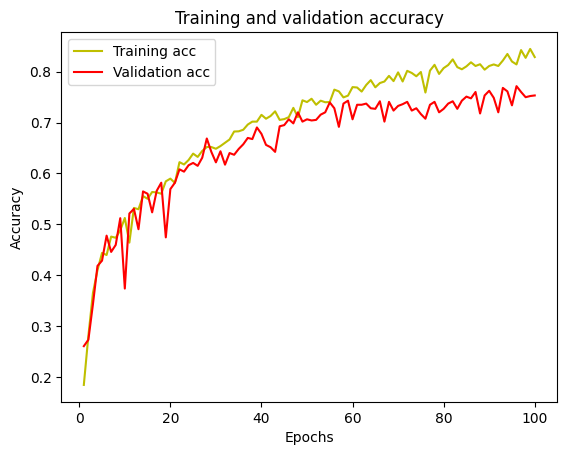

In [85]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [87]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)




28/28 [==============================] - 3s 94ms/step


In [88]:
cm = confusion_matrix(y_true, y_pred_classes)


In [89]:
cm

array([[113,  12,  15,   8,   0,   1,   0],
       [ 16,  86,  13,   6,   5,   1,   1],
       [ 11,   7,  79,   0,  15,   8,   0],
       [  0,   2,   0, 126,   0,   0,   0],
       [  8,   9,  13,   0,  64,  18,   0],
       [  9,   2,   7,   1,  23,  66,   5],
       [  0,   0,   0,   0,   0,   0, 125]])